###  Common imports

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

### Loading and pre_processing dataset

In [2]:
image_path = './'

transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root = image_path, train = True, transform=transform, download=True)

In [11]:
from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(5000))
# mnist_train_dataset = Subset(mnist_dataset, torch.arange(5000, len(mnist_dataset)))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(5000, 35000))
mnist_test_dataset = torchvision.datasets.MNIST(root= image_path, train=False, transform= transform, download=False)

### Constructing dataloader 


In [12]:
from torch.utils.data import DataLoader


batch_size = 20
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size = batch_size, shuffle = False)


### Constructing the model


In [13]:
def cnn_model(filters = [32, 64] , batch_norm = False, actfn = nn.ReLU(), pooling = nn.MaxPool2d(kernel_size= 2), dropout = True) :
	model = nn.Sequential()
	model.add_module(
		'conv1', 
		nn.Conv2d(
			in_channels= 1, out_channels=filters[0],
			kernel_size= 5, padding= 2)
	)	
	model.add_module('relu1', actfn)
	model.add_module('pool1', pooling)
	if batch_norm == True :
		model.add_module('batch normalization', nn.BatchNorm2d(filters[0]))
	model.add_module('conv2',
		nn.Conv2d(
			in_channels= filters[0], out_channels= filters[1],
			kernel_size= 5, padding= 2)
		)
	model.add_module('relu2', actfn)
	model.add_module('pool2', pooling)
	model.add_module('flatten', nn.Flatten())
	x = torch.ones(4, 1, 28, 28)
	fc_input = model(x).shape
	model.add_module('fc1', nn.Linear(fc_input[1], 1024))
	model.add_module('relu3', actfn)
	if dropout == True :	
		model.add_module('drop', nn.Dropout(p= 0.5))
	model.add_module('fc2', nn.Linear(1024, 10))
	return model

#### Calculating the number of parameters

In [15]:
model = cnn_model()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params = count_parameters(model)
params

3274634

### Defining the training function

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

def train(model, num_epochs, train_dl, valid_dl) :
	loss_hist_train = [0] * num_epochs
	acc_hist_train = [0] * num_epochs
	loss_hist_valid = [0] * num_epochss
	acc_hist_valid = [0] * num_epochs
	for epoch in range(num_epochs) :
		model.train()
		for x_batch, y_batch in train_dl :
			pred = model(x_batch)
			loss = loss_fn(pred, y_batch)
			loss.backward()	#backpropagate
			optimizer.step()	#optimize backpropagation
			optimizer.zero_grad()	#zero the gradients in preparation for the next batch
			loss_hist_train[epoch] += loss.item()*y_batch.size(0) # loss multiplied by the batch size to get full batch loss
			is_correct = (
				torch.argmax(pred, dim = 1) == y_batch
			).float() # gets the largest prediction value over the 10 epochs and compares it with the y value to get a 0 or 1
			# is_correct_test = (
			# 	torch.argmax(pred, dim = 1)
			# ).float()
			acc_hist_train[epoch] += is_correct.sum() # sums up no of correct predictions per epoch per batch
		loss_hist_train[epoch] /= len(train_dl.dataset) # gets overall loss
		acc_hist_train[epoch] /= len(train_dl.dataset)	# gets overall accuracy
	
		model.eval()
		with torch.no_grad() :
			for x_batch, y_batch in valid_dl :
				pred = model(x_batch)
				loss = loss_fn(pred, y_batch)
				loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
				is_correct = (
					torch.argmax(pred, dim = 1) == y_batch
				).float()
				acc_hist_valid[epoch] += is_correct.sum()
		loss_hist_valid[epoch] /= len(valid_dl.dataset)
		acc_hist_valid[epoch] /= len(valid_dl.dataset)

		print(f'Epoch {epoch + 1} accuracy : {acc_hist_train[epoch]:.4f} val_accuracy :{acc_hist_valid[epoch]:.4f} \
			 training loss : {loss_hist_train[epoch]:.4f} validation_loss : {loss_hist_valid[epoch]:.4f}')
	return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid



## Function for Plotting loss and accuracy curves

In [18]:
def plot_curves(hist):
	x_axis = np.arange(len(hist[0])) + 1
	fig = plt.figure(figsize = (12, 4))
	ax = fig.add_subplot(1, 2, 1)
	ax.plot(x_axis, hist[0], '-o', label = 'train loss')
	ax.plot(x_axis, hist[1], '--<', label = 'validation loss')
	ax.legend(fontsize = 15)
	ax.set_ylabel('Loss', size = 15)
	ax.set_xlabel('Epoch', size = 15)
	ax = fig.add_subplot(1, 2, 2)
	ax.plot(x_axis, hist[2], '-o', label = 'train accuracy')
	ax.plot(x_axis, hist[3], '--<', label = 'validation accuracy')
	ax.legend(fontsize = 15)
	ax.set_xlabel('Epoch', size = 15)
	ax.set_ylabel('Accuracy', size = 15)

# Experimentation

### Max Pooling vs Average Pooling

Pooling type  = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Epoch 1 accuracy : 0.7330 val_accuracy :0.9210 			 training loss : 0.8265 validation_loss : 0.2838
Epoch 2 accuracy : 0.9345 val_accuracy :0.9480 			 training loss : 0.2232 validation_loss : 0.1788
Epoch 3 accuracy : 0.9670 val_accuracy :0.9450 			 training loss : 0.1236 validation_loss : 0.1713
Epoch 4 accuracy : 0.9760 val_accuracy :0.9590 			 training loss : 0.0869 validation_loss : 0.1608
Epoch 5 accuracy : 0.9775 val_accuracy :0.9580 			 training loss : 0.0663 validation_loss : 0.1758
Epoch 6 accuracy : 0.9855 val_accuracy :0.9670 			 training loss : 0.0460 validation_loss : 0.1371
Epoch 7 accuracy : 0.9885 val_accuracy :0.9600 			 training loss : 0.0348 validation_loss : 0.1510
Epoch 8 accuracy : 0.9855 val_accuracy :0.9610 			 training loss : 0.0402 validation_loss : 0.1658
Epoch 9 accuracy : 0.9955 val_accuracy :0.9530 			 training loss : 0.0240 validation_loss : 0.1822
Epoch 10 accuracy 

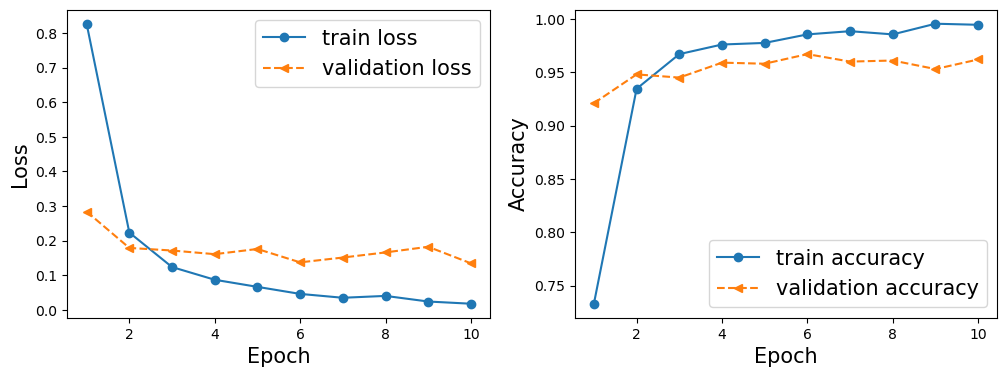

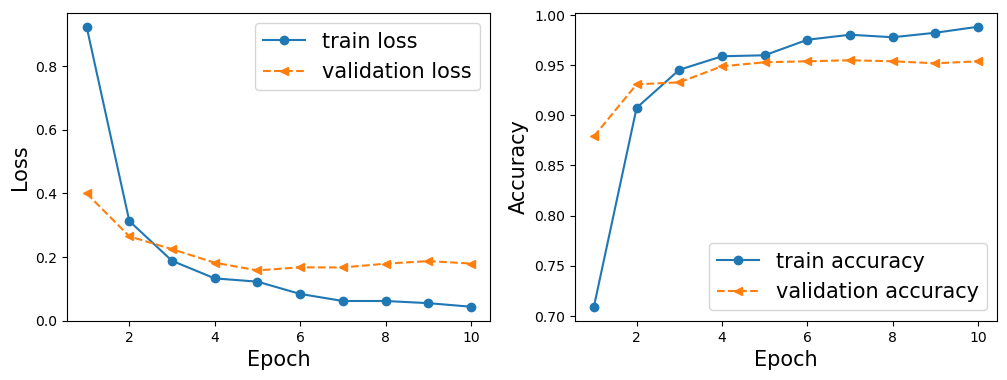

In [35]:
pooling = [nn.MaxPool2d(kernel_size = 2), nn.AvgPool2d(kernel_size = 2)]

for n in pooling :
	print(f'Pooling type  = {n}')
	model = cnn_model(pooling = n)
	loss_fn = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
	torch.manual_seed(14)
	hist = train(model, 10, train_dl, valid_dl)
	plot_curves(hist)

### ReLU vs PReLU

Activation function =  ReLU()
Epoch 1 accuracy : 0.7465 val_accuracy :0.9200 			 training loss : 0.8093 validation_loss : 0.2649
Epoch 2 accuracy : 0.9280 val_accuracy :0.9480 			 training loss : 0.2403 validation_loss : 0.1826
Epoch 3 accuracy : 0.9590 val_accuracy :0.9500 			 training loss : 0.1316 validation_loss : 0.1559
Epoch 4 accuracy : 0.9730 val_accuracy :0.9620 			 training loss : 0.0995 validation_loss : 0.1386
Epoch 5 accuracy : 0.9780 val_accuracy :0.9560 			 training loss : 0.0751 validation_loss : 0.1373
Epoch 6 accuracy : 0.9820 val_accuracy :0.9600 			 training loss : 0.0463 validation_loss : 0.1610
Epoch 7 accuracy : 0.9850 val_accuracy :0.9620 			 training loss : 0.0432 validation_loss : 0.1411
Epoch 8 accuracy : 0.9885 val_accuracy :0.9650 			 training loss : 0.0328 validation_loss : 0.1379
Epoch 9 accuracy : 0.9940 val_accuracy :0.9400 			 training loss : 0.0265 validation_loss : 0.2305
Epoch 10 accuracy : 0.9925 val_accuracy :0.9680 			 training loss : 0.0269 vali

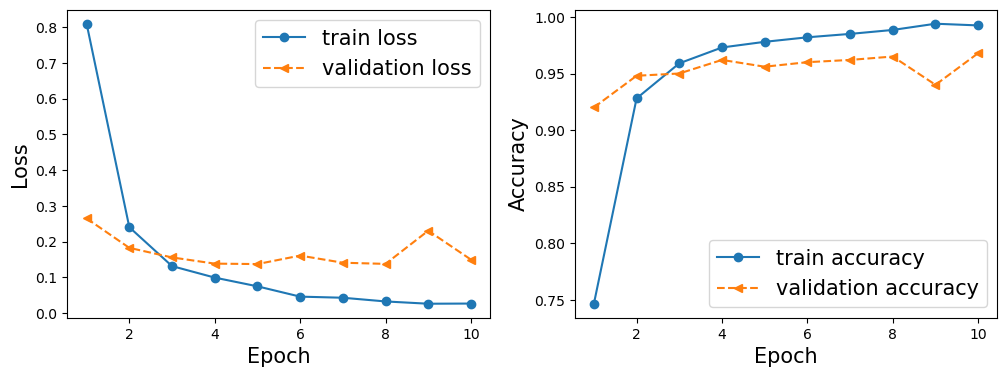

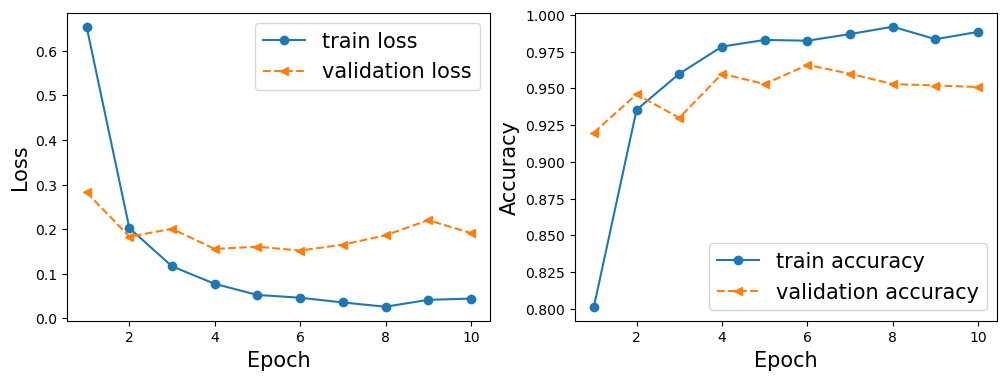

In [36]:
activation = [nn.ReLU(), nn.PReLU()]

for n in activation :
	print(f'Activation function =  {n}')
	model = cnn_model(actfn = n)
	loss_fn = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
	torch.manual_seed(14)
	hist = train(model, 10, train_dl, valid_dl)
	plot_curves(hist)

### Batch normalization

Batch normalization : False
Epoch 1 accuracy : 0.7465 val_accuracy :0.9200 			 training loss : 0.8093 validation_loss : 0.2649
Epoch 2 accuracy : 0.9280 val_accuracy :0.9480 			 training loss : 0.2403 validation_loss : 0.1826
Epoch 3 accuracy : 0.9590 val_accuracy :0.9500 			 training loss : 0.1316 validation_loss : 0.1559
Epoch 4 accuracy : 0.9730 val_accuracy :0.9620 			 training loss : 0.0995 validation_loss : 0.1386
Epoch 5 accuracy : 0.9780 val_accuracy :0.9560 			 training loss : 0.0751 validation_loss : 0.1373
Epoch 6 accuracy : 0.9820 val_accuracy :0.9600 			 training loss : 0.0463 validation_loss : 0.1610
Epoch 7 accuracy : 0.9850 val_accuracy :0.9620 			 training loss : 0.0432 validation_loss : 0.1411
Epoch 8 accuracy : 0.9885 val_accuracy :0.9650 			 training loss : 0.0328 validation_loss : 0.1379
Epoch 9 accuracy : 0.9940 val_accuracy :0.9400 			 training loss : 0.0265 validation_loss : 0.2305
Epoch 10 accuracy : 0.9925 val_accuracy :0.9680 			 training loss : 0.0269 valida

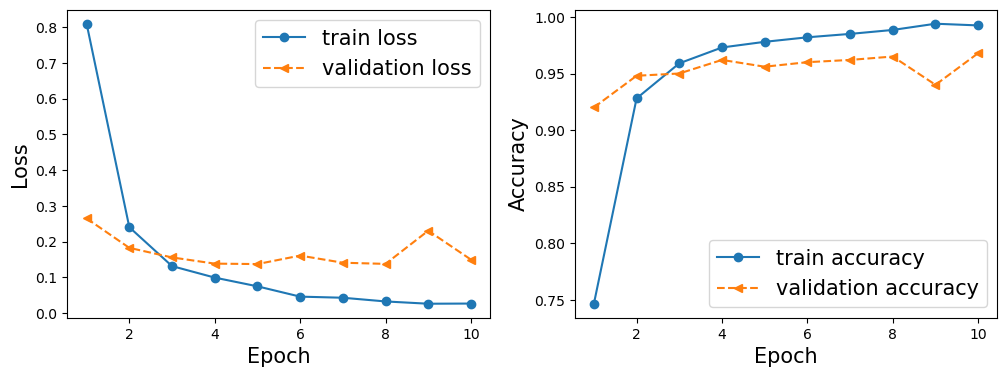

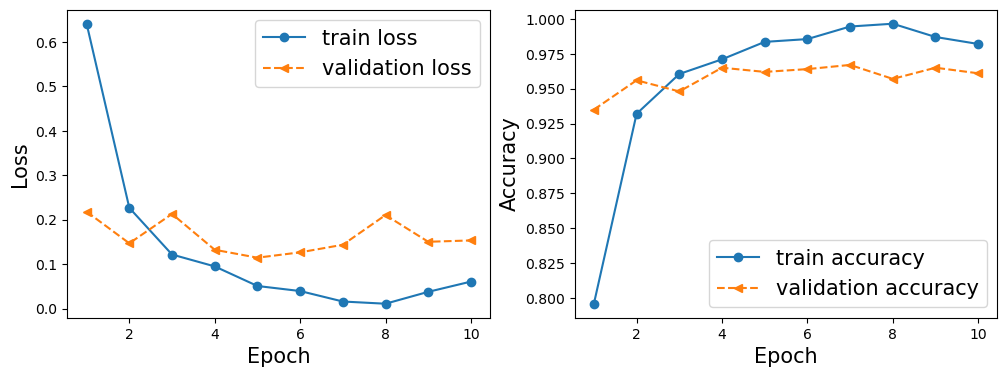

In [37]:
batch_norm = [False, True]

for n in batch_norm :
	print(f'Batch normalization : {n}')
	model = cnn_model(batch_norm = n)
	loss_fn = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
	torch.manual_seed(14)
	hist = train(model, 10, train_dl, valid_dl)
	plot_curves(hist)

### Number of filters

Number of filters = [2, 2]
Epoch 1 accuracy : 0.3920 val_accuracy :0.7530 			 training loss : 1.8079 validation_loss : 0.7852
Epoch 2 accuracy : 0.8015 val_accuracy :0.8210 			 training loss : 0.6378 validation_loss : 0.5608
Epoch 3 accuracy : 0.8360 val_accuracy :0.8560 			 training loss : 0.4876 validation_loss : 0.4703
Epoch 4 accuracy : 0.8775 val_accuracy :0.8710 			 training loss : 0.3883 validation_loss : 0.4123
Epoch 5 accuracy : 0.9030 val_accuracy :0.8990 			 training loss : 0.3324 validation_loss : 0.3615
Epoch 6 accuracy : 0.9120 val_accuracy :0.8890 			 training loss : 0.2920 validation_loss : 0.3799
Epoch 7 accuracy : 0.9240 val_accuracy :0.8870 			 training loss : 0.2549 validation_loss : 0.3734
Epoch 8 accuracy : 0.9235 val_accuracy :0.9010 			 training loss : 0.2237 validation_loss : 0.3328
Epoch 9 accuracy : 0.9375 val_accuracy :0.8950 			 training loss : 0.2061 validation_loss : 0.3468
Epoch 10 accuracy : 0.9400 val_accuracy :0.9150 			 training loss : 0.1901 validat

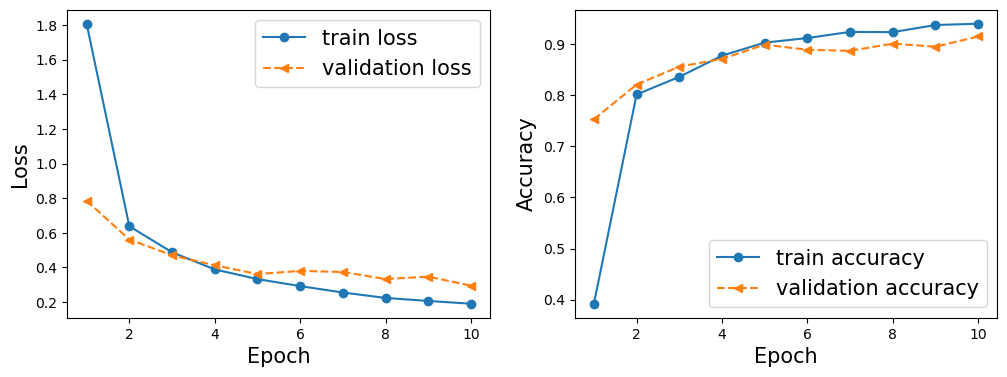

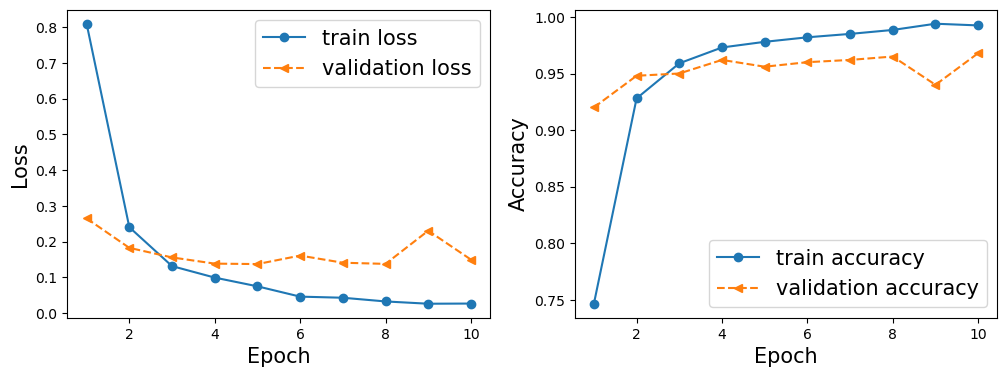

In [12]:
filters = [[2, 2],  [32, 64]]

for n in  filters :
	print(f'Number of filters = {n}')
	model = cnn_model(filters = n)
	loss_fn = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
	torch.manual_seed(14)
	hist = train(model, 10, train_dl, valid_dl)
	plot_curves(hist)



## Final Optimized model

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model = cnn_model()

In [17]:
torch.manual_seed(14)
hist = train(model, 10, train_dl, valid_dl)


Epoch 1 accuracy : 0.9452 val_accuracy :0.9826 			 training loss : 0.1722 validation_loss : 0.0558
Epoch 2 accuracy : 0.9814 val_accuracy :0.9882 			 training loss : 0.0619 validation_loss : 0.0427
Epoch 3 accuracy : 0.9870 val_accuracy :0.9898 			 training loss : 0.0402 validation_loss : 0.0430
Epoch 4 accuracy : 0.9902 val_accuracy :0.9878 			 training loss : 0.0302 validation_loss : 0.0486
Epoch 5 accuracy : 0.9920 val_accuracy :0.9904 			 training loss : 0.0257 validation_loss : 0.0453
Epoch 6 accuracy : 0.9932 val_accuracy :0.9930 			 training loss : 0.0197 validation_loss : 0.0390
Epoch 7 accuracy : 0.9961 val_accuracy :0.9880 			 training loss : 0.0142 validation_loss : 0.0570
Epoch 8 accuracy : 0.9940 val_accuracy :0.9888 			 training loss : 0.0191 validation_loss : 0.0592
Epoch 9 accuracy : 0.9959 val_accuracy :0.9906 			 training loss : 0.0129 validation_loss : 0.0601
Epoch 10 accuracy : 0.9962 val_accuracy :0.9870 			 training loss : 0.0125 validation_loss : 0.0606


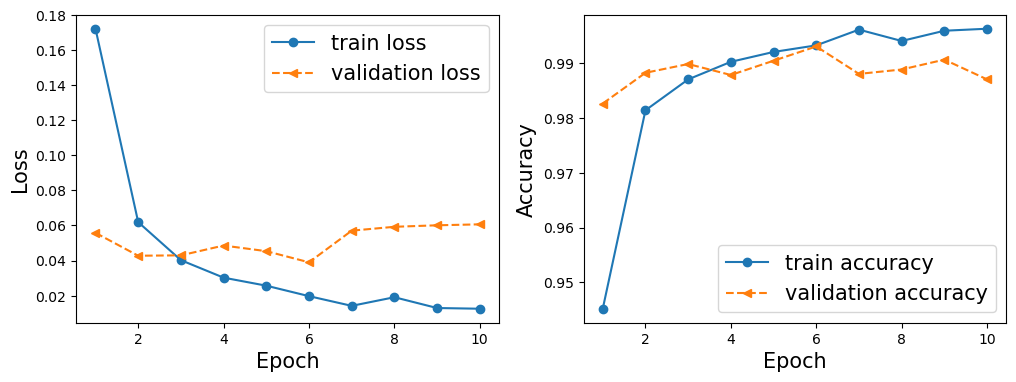

In [19]:
plot_curves(hist)

## Testing on test set

In [20]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (
	torch.argmax(pred, dim = 1) == mnist_test_dataset.targets
).float()
print(f'Test accuracy : {is_correct.mean():.4f}')

Test accuracy : 0.9860
